<a href="https://colab.research.google.com/github/lazybuttrying/AI_Project/blob/main/investment/%EC%A3%BC%EC%8B%9D%ED%88%AC%EC%9E%90DQN%26AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
from gym import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    def __init__(self, data, ):
        super(StockTradingEnv, self).__init__()

        self.current_step = 0
        self.max_steps = len(data) - 1

        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: stock price and cash balance
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,))

        self.stock_price_history = data
        self.cash_balance = 10000

    def reset(self):
        self.current_step = 0
        self.cash_balance = 10000
        return [self.stock_price_history[self.current_step], self.cash_balance]

    def step(self, action):
        self.current_step += 1
        done = False

        # Execute action
        if action == 0:  # Buy
            if self.cash_balance >= self.stock_price_history[self.current_step]:
                self.cash_balance -= self.stock_price_history[self.current_step]
            else:
                reward = -1  # Negative reward for invalid action
        elif action == 1:  # Hold
            pass
        elif action == 2:  # Sell
            self.cash_balance += self.stock_price_history[self.current_step]

        # Get reward
        reward = self.cash_balance

        # Get observation
        observation = [self.stock_price_history[self.current_step], self.cash_balance]

        # Check if done
        if self.current_step >= self.max_steps:
            done = True

        return observation, reward, done, {}

# Sample stock price
data = [10, 11, 12, 11, 10, 9, 8, 9, 10]

# Create environment
env = StockTradingEnv(data)

# Example loop
observation = env.reset()
for _ in range(env.max_steps):
    action = env.action_space.sample()  # Random action for now
    print(action)
    observation, reward, done, _ = env.step(action)
    print(observation, reward, done)
    if done:
        break

2
[11, 10011] 10011 False
2
[12, 10023] 10023 False
2
[11, 10034] 10034 False
0
[10, 10024] 10024 False
1
[9, 10024] 10024 False
1
[8, 10024] 10024 False
1
[9, 10024] 10024 False
1
[10, 10024] 10024 True


# 환경 정의

In [ ]:
import gym
from gym import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()

        self.initial_balance = initial_balance
        self.current_step = 0
        self.max_steps = len(data) - 1

        # Action space: Buy, Hold, Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: stock price, portfolio value, and cash balance
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3,))

        self.stock_price_history = data
        self.portfolio_value = self.initial_balance
        self.cash_balance = self.initial_balance

    def reset(self):
        self.current_step = 0
        self.portfolio_value = self.initial_balance
        self.cash_balance = self.initial_balance
        return [self.stock_price_history[self.current_step], self.portfolio_value, self.cash_balance]

    def step(self, action):
        self.current_step += 1
        done = False

        shares_bought = 1  # Assign default value
        shares_sold = 1  # Assign default value
        # Execute action
        if action == 0:  # Buy
            if self.cash_balance >= self.stock_price_history[self.current_step]:
                # 잔액을 몰빵 투자
                shares_bought = self.cash_balance // self.stock_price_history[self.current_step]
                self.cash_balance -= shares_bought * self.stock_price_history[self.current_step]
            else:
                shares_bought = 0
        elif action == 1:  # Hold
            shares_bought = 0
            shares_sold = 0
        elif action == 2:  # Sell
            if self.portfolio_value > 0:
                shares_sold = min(self.portfolio_value, self.cash_balance) // self.stock_price_history[self.current_step]
                self.cash_balance += shares_sold * self.stock_price_history[self.current_step]
            else:
                shares_sold = 0

        # Update portfolio value
        self.portfolio_value = self.cash_balance + (shares_bought * self.stock_price_history[self.current_step])

        # Get reward
        reward = self.portfolio_value

        # Get observation
        observation = [self.stock_price_history[self.current_step], self.portfolio_value, self.cash_balance]


        # Check if done
        if self.current_step >= self.max_steps:
            done = True

        return observation, reward, done, {}

# Sample stock price
data = [10, 11, 12, 11, 10, 9, 8, 9, 10]

# Create environment
env = StockTradingEnv(data)

# Example loop
observation = env.reset()
for _ in range(env.max_steps):
    action = env.action_space.sample()  # Random action for now
    print(action)
    observation, reward, done, _ = env.step(action)
    print(observation, reward, done)
    # [stock price, portfolio value, cash balance] portfolio value, done
    if done:
        break

2
[11, 20010, 19999] 20010 False
1
[12, 19999, 19999] 19999 False
0
[11, 19999, 1] 19999 False
0
[10, 1, 1] 1 False
2
[9, 10, 1] 10 False
1
[8, 1, 1] 1 False
0
[9, 1, 1] 1 False
0
[10, 1, 1] 1 True


# DQN
## CartPole

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import namedtuple, deque

# Define the neural network for Q-function approximation
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def append(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states = torch.FloatTensor([e.state for e in batch])
        actions = torch.LongTensor([e.action for e in batch])
        rewards = torch.FloatTensor([e.reward for e in batch])
        next_states = torch.FloatTensor([e.next_state for e in batch])
        dones = torch.BoolTensor([e.done for e in batch])
        return states, actions, rewards, next_states, dones

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=int(1e5), batch_size=64, gamma=0.99, lr=1e-3, update_freq=4, target_update_freq=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.update_freq = update_freq
        self.target_update_freq = target_update_freq
        self.q_network = DQN(state_size, action_size)
        self.target_network = DQN(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.steps = 0

    def select_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_network(state)
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.append(state, action, reward, next_state, done)

    def train(self):
        if len(self.replay_buffer.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        print(self.q_network(states).shape, actions.shape, actions.unsqueeze(1).shape)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

# Initialize the environment and agent
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
max_episodes = 1000
max_steps_per_episode = 1000

epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward}, Epsilon: {epsilon}")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size([64]) torch.Size([64, 1])
torch.Size([64, 2]) torch.Size(

KeyboardInterrupt: 

In [ ]:
# 테스트용 코드
total_rewards = []

for episode in range(10):  # 총 10 에피소드 테스트
    state = env.reset()
    episode_reward = 0

    while True:
        action = agent.select_action(state, epsilon=0)  # 엡실론을 0으로 설정하여 탐험 없이 최적 행동 선택
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

        if done:
            total_rewards.append(episode_reward)
            print(f"Episode {episode + 1}: Reward: {episode_reward}")
            break

print(f"Average Reward: {np.mean(total_rewards)}")


Episode 1: Reward: 500.0
Episode 2: Reward: 500.0
Episode 3: Reward: 500.0
Episode 4: Reward: 500.0
Episode 5: Reward: 500.0
Episode 6: Reward: 500.0
Episode 7: Reward: 500.0
Episode 8: Reward: 500.0
Episode 9: Reward: 500.0
Episode 10: Reward: 500.0
Average Reward: 500.0


## 주식투자로 테스트

In [ ]:

# Sample stock price
data = [10, 11, 12, 11, 10, 9, 8, 9, 10]

# Create environment
env = StockTradingEnv(data)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Define training parameters
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 0.995
max_episodes = 1000
max_steps_per_episode = 1000


epsilon = epsilon_start
for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        agent.store_experience(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward
        if done:
            break
    epsilon = max(epsilon_final, epsilon * epsilon_decay)
    if episode % 50 == 0:
      print(f"Episode: {episode}, Reward: {episode_reward}, Epsilon: {epsilon}")

Episode: 50, Reward: 20084, Epsilon: 0.778312557068642
Episode: 100, Reward: 140037, Epsilon: 0.6057704364907278
Episode: 150, Reward: 220028, Epsilon: 0.47147873742168567
Episode: 200, Reward: 5098232, Epsilon: 0.3669578217261671
Episode: 250, Reward: 40089, Epsilon: 0.285607880564032
Episode: 300, Reward: 739868, Epsilon: 0.22229219984074702
Episode: 350, Reward: 5098232, Epsilon: 0.1730128104744653
Episode: 400, Reward: 5098232, Epsilon: 0.1346580429260134
Episode: 450, Reward: 220036, Epsilon: 0.10480604571960442
Episode: 500, Reward: 5098232, Epsilon: 0.08157186144027828
Episode: 550, Reward: 5098232, Epsilon: 0.06348840406243188
Episode: 600, Reward: 939764, Epsilon: 0.0494138221100385
Episode: 650, Reward: 5098232, Epsilon: 0.03845939824099909
Episode: 700, Reward: 5098232, Epsilon: 0.029933432588273214
Episode: 750, Reward: 5098232, Epsilon: 0.023297566459620722
Episode: 800, Reward: 5098232, Epsilon: 0.018132788524664028
Episode: 850, Reward: 5098232, Epsilon: 0.01411297700341

In [ ]:
# 테스트용 코드
total_rewards = []

for episode in range(10):  # 총 10 에피소드 테스트
    state = env.reset()
    episode_reward = 0

    while True:
        action = agent.select_action(state, epsilon=0)  # 엡실론을 0으로 설정하여 탐험 없이 최적 행동 선택
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        state = next_state

        if done:
            total_rewards.append(episode_reward)
            print(f"Episode {episode + 1}: Reward: {episode_reward}")
            break

print(f"Average Reward: {np.mean(total_rewards)}")


Episode 1: Reward: 5098232
Episode 2: Reward: 5098232
Episode 3: Reward: 5098232
Episode 4: Reward: 5098232
Episode 5: Reward: 5098232
Episode 6: Reward: 5098232
Episode 7: Reward: 5098232
Episode 8: Reward: 5098232
Episode 9: Reward: 5098232
Episode 10: Reward: 5098232
Average Reward: 5098232.0


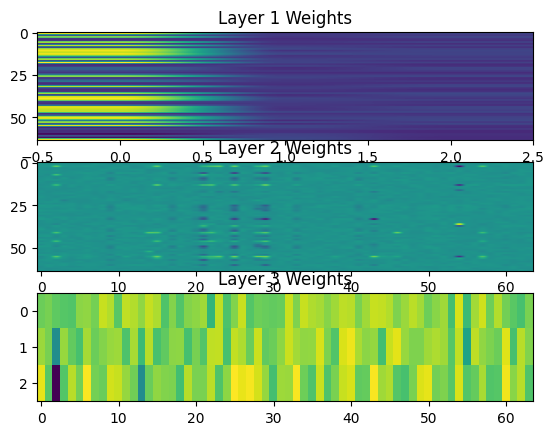

In [ ]:
import matplotlib.pyplot as plt

def visualize_weights(model):
    # 각 레이어의 가중치를 추출합니다.
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.detach().numpy())

    # 가중치를 시각화합니다.
    fig, axs = plt.subplots(len(weights))
    if len(weights) == 1:
        axs = [axs]
    for i, weight in enumerate(weights):
        axs[i].imshow(weight, cmap='viridis', aspect='auto')
        axs[i].set_title(f'Layer {i+1} Weights')
    plt.show()

# 모델 가중치 시각화
visualize_weights(agent.q_network)


# Actor Critic
## Cartpole


64는 네트워크의 은닉층(hidden layer) 크기입니다. 은닉층의 크기는 모델의 복잡성을 조절하는 중요한 하이퍼파라미터(hyperparameter) 중 하나입니다. 네트워크의 은닉층이 클수록 모델의 표현력이 높아지지만, 더 많은 파라미터가 필요하고 학습이 더 오래 걸릴 수 있습니다. 반대로 은닉층이 작을수록 모델의 복잡성이 감소하고 일반화 성능이 향상될 수 있지만, 모델이 덜 유연해질 수 있습니다.

64로 선택된 이유는 경험적으로 좋은 성능을 보이는 값일 수 있습니다. 물론 이 값은 문제에 따라 다를 수 있으며, 실제로는 여러 가지 다른 은닉층 크기를 실험하여 최적의 값을 찾아야 합니다. 종종 2의 제곱수로 선택되는 경향이 있습니다(예: 32, 64, 128, 256 등) 그 이유는 하드웨어에서의 연산 효율성 때문입니다.

따라서 은닉층 크기를 선택할 때는 문제의 복잡성, 데이터의 특성, 계산 리소스 등을 고려하여 적절한 값을 선택해야 합니다. 일반적으로는 작은 네트워크부터 시작하여 성능이 충분하지 않을 때까지 크기를 증가시키고, 과적합(overfitting)이 발생하지 않는 선에서 가장 작은 네트워크를 선택하는 것이 좋습니다.

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # Critic는 단일 값만 출력 (V-value)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Actor-Critic 에이전트 정의
class ActorCriticAgent:
    def __init__(self, state_size, action_size, lr_actor=1e-3, lr_critic=1e-3, gamma=0.99):
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma

    def select_action(self, state):
        state = torch.FloatTensor(state)
        action_probs = self.actor(state)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()
        return action

    def train(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state)
        next_state = torch.FloatTensor(next_state)
        reward = torch.FloatTensor([reward])
        value = self.critic(state)
        next_value = self.critic(next_state).detach()
        td_target = reward + self.gamma * next_value * (1 - done)
        td_error = td_target - value

        # Critic 업데이트
        critic_loss = td_error.pow(2).mean()
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        # Actor 업데이트
        action_probs = self.actor(state)
        action_dist = torch.distributions.Categorical(action_probs)
        log_prob = action_dist.log_prob(action)
        actor_loss = -log_prob * td_error.detach()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

# 환경 및 에이전트 초기화
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = ActorCriticAgent(state_size, action_size)

# 에이전트 학습
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
    if episode % 50 == 0:
      print(f"Episode {episode + 1}: Reward: {episode_reward}")


Episode 1: Reward: 10.0
Episode 51: Reward: 9.0
Episode 101: Reward: 10.0
Episode 151: Reward: 20.0
Episode 201: Reward: 20.0
Episode 251: Reward: 37.0
Episode 301: Reward: 67.0


KeyboardInterrupt: 

In [ ]:
total_rewards = []

for episode in range(10):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        episode_reward += reward
    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward: {episode_reward}")

print(f"Average Reward: {sum(total_rewards) / num_episodes}")

Episode 1: Reward: 132.0
Episode 2: Reward: 142.0
Episode 3: Reward: 107.0
Episode 4: Reward: 156.0
Episode 5: Reward: 126.0
Episode 6: Reward: 218.0
Episode 7: Reward: 166.0
Episode 8: Reward: 111.0
Episode 9: Reward: 216.0
Episode 10: Reward: 112.0
Average Reward: 1.486


## 주식투자

In [ ]:

# Sample stock price
data = [10, 11, 12, 11, 10, 9, 8, 9, 10]

# Create environment
env = StockTradingEnv(data)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = ActorCriticAgent(state_size, action_size)

# 에이전트 학습
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        agent.train(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
    if episode % 50 == 0:
      print(f"Episode {episode + 1}: Reward: {episode_reward}")

Episode 1: Reward: 80080
Episode 51: Reward: 80080
Episode 101: Reward: 80080
Episode 151: Reward: 80080
Episode 201: Reward: 80080
Episode 251: Reward: 80080
Episode 301: Reward: 80080
Episode 351: Reward: 80080
Episode 401: Reward: 80080
Episode 451: Reward: 80080
Episode 501: Reward: 80080
Episode 551: Reward: 80080
Episode 601: Reward: 80080
Episode 651: Reward: 80080
Episode 701: Reward: 80080
Episode 751: Reward: 80080
Episode 801: Reward: 80080
Episode 851: Reward: 80080
Episode 901: Reward: 80080
Episode 951: Reward: 80080


In [ ]:
total_rewards = []

for episode in range(10):
    state = env.reset()
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        state = next_state
        episode_reward += reward
    total_rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Reward: {episode_reward}")

print(f"Average Reward: {sum(total_rewards) / num_episodes}")

Episode 1: Reward: 80080
Episode 2: Reward: 80080
Episode 3: Reward: 80080
Episode 4: Reward: 80080
Episode 5: Reward: 80080
Episode 6: Reward: 80080
Episode 7: Reward: 80080
Episode 8: Reward: 80080
Episode 9: Reward: 80080
Episode 10: Reward: 80080
Average Reward: 800.8


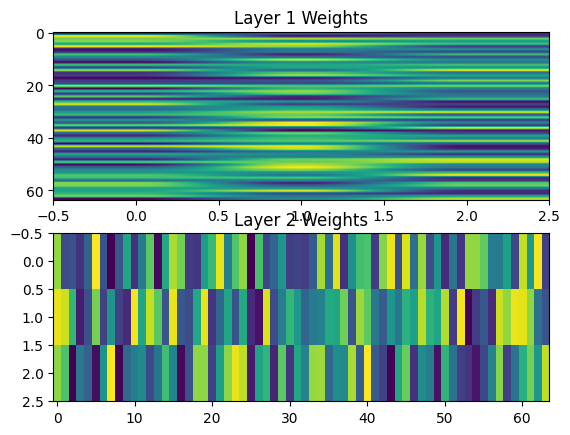

In [ ]:
visualize_weights(agent.actor)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


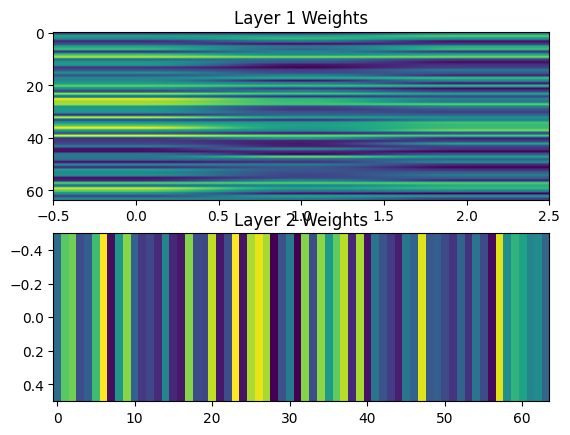

In [ ]:
visualize_weights(agent.critic)

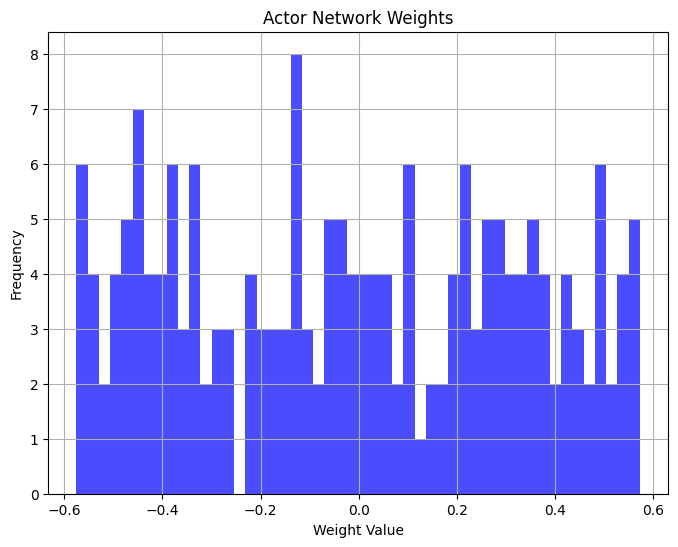

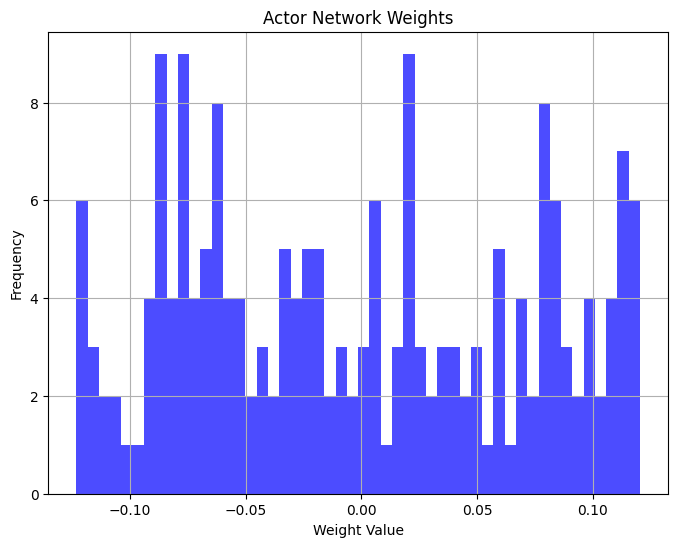

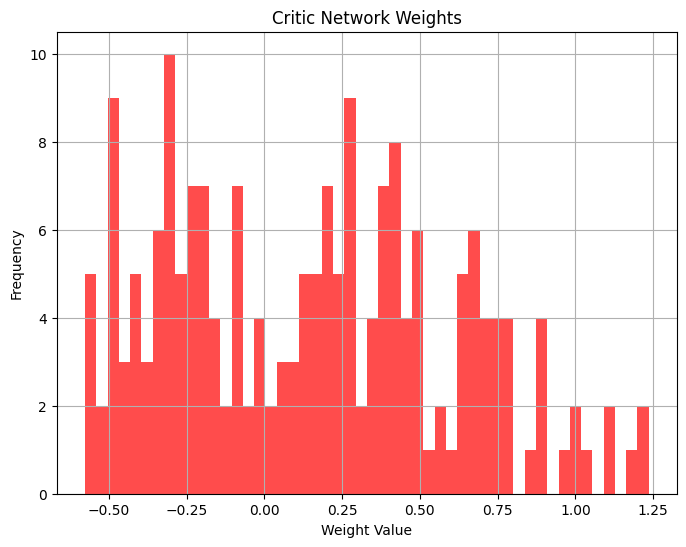

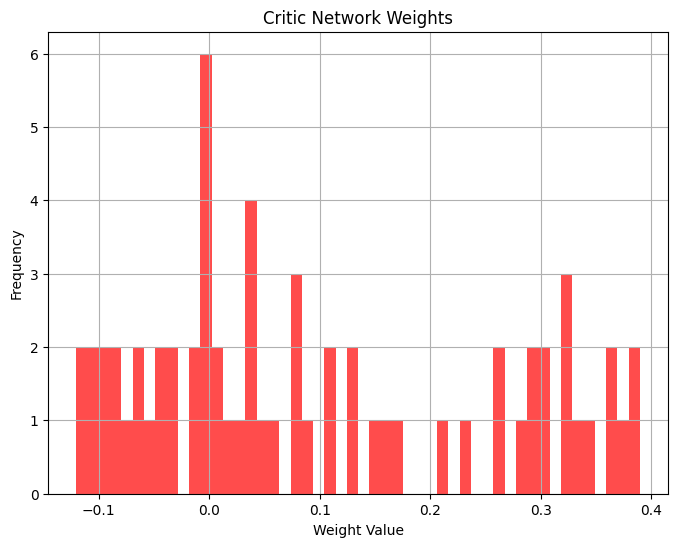

In [ ]:
import matplotlib.pyplot as plt

# Actor 네트워크의 가중치 시각화
def visualize_actor_weights(actor_network):
    for name, param in actor_network.named_parameters():
        if 'weight' in name:
            weights = param.data.numpy()
            plt.figure(figsize=(8, 6))
            plt.hist(weights.flatten(), bins=50, alpha=0.7, color='blue')
            plt.title('Actor Network Weights')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

# Critic 네트워크의 가중치 시각화
def visualize_critic_weights(critic_network):
    for name, param in critic_network.named_parameters():
        if 'weight' in name:
            weights = param.data.numpy()
            plt.figure(figsize=(8, 6))
            plt.hist(weights.flatten(), bins=50, alpha=0.7, color='red')
            plt.title('Critic Network Weights')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

# Actor 네트워크의 가중치 시각화
visualize_actor_weights(agent.actor)

# Critic 네트워크의 가중치 시각화
visualize_critic_weights(agent.critic)
